In [1]:
# https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from model.faster_rcnn_vgg16 import FasterRCNNVGG16
from utils.dataset import *
from utils import torch_utils
from utils.config import opt

In [2]:
torch.backends.cudnn.benchmark = True
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [3]:
# specify visible GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch_utils.select_device()

using CPU...


In [4]:
trainset = LoadDataset(opt.data_dir, opt.split);len(trainset)

5011

In [5]:
trainset[140][0].shape # 短边为600， 长边不固定

torch.Size([3, 600, 800])

shape:(600, 791, 3),dtype:uint8


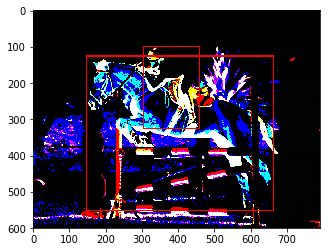

In [10]:
img = show_one_image(trainset[5][0], trainset[5][1])

In [6]:
img = trainset[140][0];img.shape

torch.Size([3, 600, 800])

In [7]:
gt = trainset[140][1];gt.shape

torch.Size([2, 4])

In [13]:
trainloader = DataLoader(trainset, batch_size=opt.batch_size, num_workers=opt.num_workers, shuffle=True)

In [7]:
faster_rcnn = FasterRCNNVGG16()

NameError: name 'load_kernel' is not defined

In [11]:
# https://github.com/rbgirshick/py-faster-rcnn/blob/master/lib/rpn/generate_anchors.py
def Generate_anchors(base_size=16, ratios=[0.5, 1, 2],
                     scales=[8, 16, 32]):
    base_anchor = np.array([1, 1, base_size, base_size]) - 1
    anchors = []
    w, h, x_ctr, y_ctr = whctrs(base_anchor) # 16 16 7.5 7.5
    size = w*h # 256
    for ratio in ratios:
        size_ratio = size/ratio # 512 256 128 
        ws = np.round(np.sqrt(size_ratio)) # 23 16 11
        hs = np.round(ws * ratio) # 12 16 22
        anchor = mkanchors(ws, hs, x_ctr, y_ctr)
        #print(anchor)
        for scale in scales:
            w, h, x_ctr, y_ctr = whctrs(anchor)
            ws = w * scale
            hs = h * scale
            ranchor = mkanchors(ws, hs, x_ctr, y_ctr)
            anchors.append(ranchor)
    return np.vstack(anchors)

In [12]:
def whctrs(anchor):
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr # 16 16 7.5 7.5

In [13]:
def mkanchors(ws, hs, x_ctr, y_ctr):

    anchor = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    return anchor

In [14]:
print(Generate_anchors())

[[ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
